# Exploration 15
# 미니프로젝트: 다양한 OCR모델 비교하기
|---평가문항---|---상세기준---|
|:------|:------|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

# Step1. 검증용 데이터셋 준비

In [1]:
import os

img_dir = os.getenv('HOME')+'/aiffel/ocr_python/books'
restaurants = os.listdir(img_dir)
restaurants

['book5.jpg', 'book6.jpg', 'book4.jpg', 'book3.jpg', 'book2.jpg', 'book1.jpg']

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
## 1. keras-ocr
keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용한다.

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

In [3]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(os.path.join(img_dir, restaurant)) for restaurant in restaurants]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, restaurant)]) for restaurant in restaurants]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


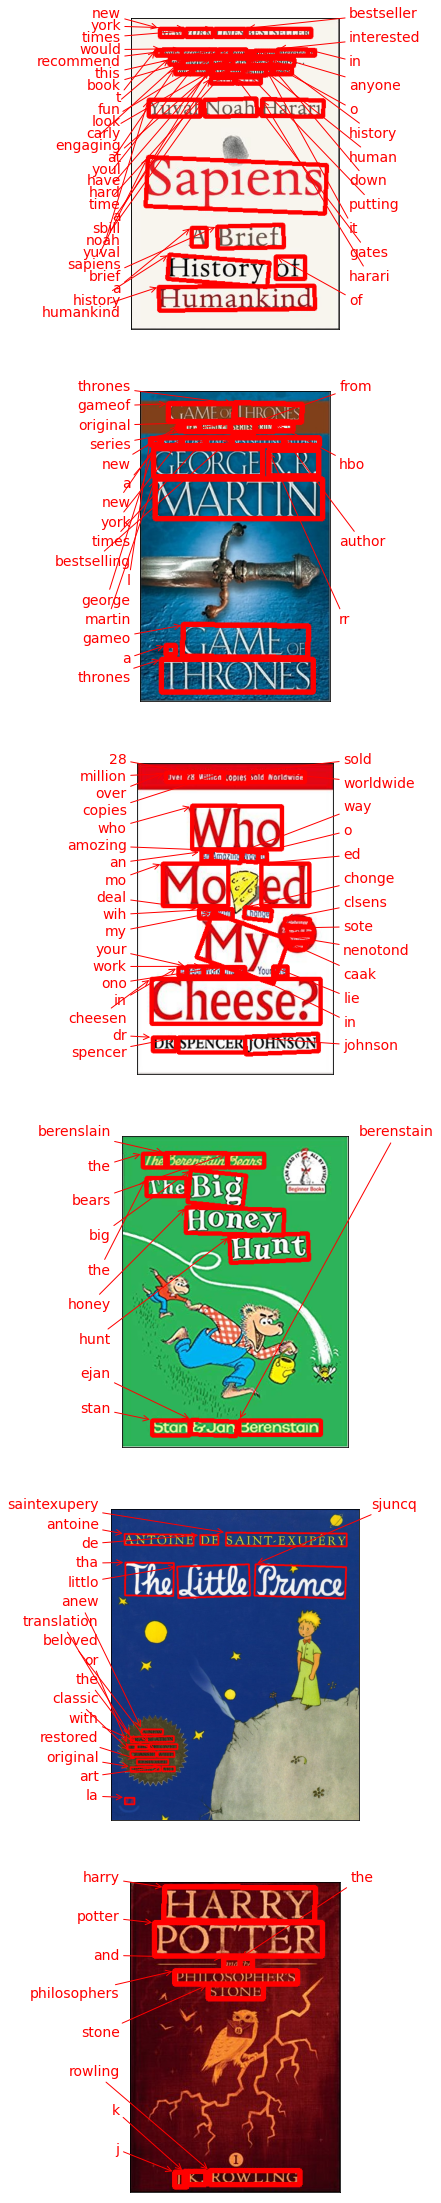

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. tesseract OCR
테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있다.

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [6]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [7]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/books'

for restaurant in restaurants:
    print(f'[{restaurant}]')
    try:
        recognize_images(os.path.join(img_dir, restaurant), save_dir)
    except:
        print(f'Cannot recognize characters from {restaurant}')

[book5.jpg]
ec“ ec ( eS


NEW

YORK

PriNMIES

BESTSELLER


Yuval

Noah

Harari

“fh

Sapiens

A

Briet

ristory

ot

Humankind

ne


Done
[book6.jpg]


TORONES

Done
[book4.jpg]

oie.

CTBT E

Worldwide

An

Amazing

Way

id


Deal

With

VQ


DR

SPENCER

JOHNSON

Done
[book3.jpg]
— i Ohm ft CS

The Berensiaun

ls elke

AWiYs

Ede

Honey

Hunt

a

i

: Wb EY . oN

ri]


Stan

$-

Jan

berenstain


> Ft) ene lc

Done
[book2.jpg]
&

ANTOINE

DFE

SAINT-EXUPERY

i ‘4 ,

Done
[book1.jpg]
i

HARRY

a.

wre

POTTER

”

BN

Borne

OOOO

EE ————————

‘4

. yi .

Nore: SE:

— >

1)

-

}.K.

ROW LING

Done


# Step3. 테스트 결과 정리

In [8]:
def compare_ocr(restaurant):
    print('[keras-ocr]')
    idx = restaurants.index(restaurant)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('[Tesseract]')
    recognize_images(os.path.join(img_dir, restaurant), save_dir)

[keras-ocr]


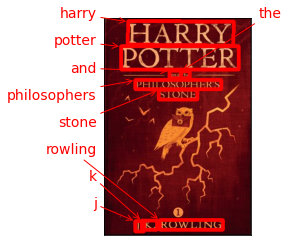

[Tesseract]
i

HARRY

a.

wre

POTTER

”

BN

Borne

OOOO

EE ————————

‘4

. yi .

Nore: SE:

— >

1)

-

}.K.

ROW LING

Done


In [9]:
compare_ocr('book1.jpg')

[keras-ocr]


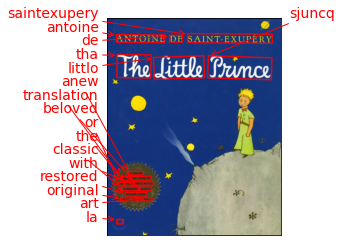

[Tesseract]
&

ANTOINE

DFE

SAINT-EXUPERY

i ‘4 ,

Done


In [10]:
compare_ocr('book2.jpg')

[keras-ocr]


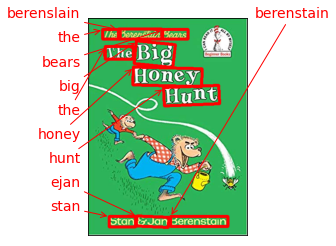

[Tesseract]
— i Ohm ft CS

The Berensiaun

ls elke

AWiYs

Ede

Honey

Hunt

a

i

: Wb EY . oN

ri]


Stan

$-

Jan

berenstain


> Ft) ene lc

Done


In [11]:
compare_ocr('book3.jpg')

[keras-ocr]


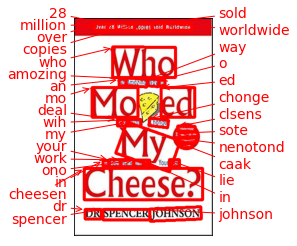

[Tesseract]

oie.

CTBT E

Worldwide

An

Amazing

Way

id


Deal

With

VQ


DR

SPENCER

JOHNSON

Done


In [12]:
compare_ocr('book4.jpg')

[keras-ocr]


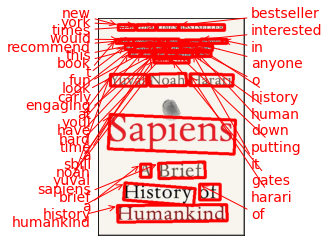

[Tesseract]
ec“ ec ( eS


NEW

YORK

PriNMIES

BESTSELLER


Yuval

Noah

Harari

“fh

Sapiens

A

Briet

ristory

ot

Humankind

ne


Done


In [13]:
compare_ocr('book5.jpg')

[keras-ocr]


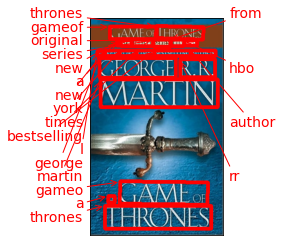

[Tesseract]


TORONES

Done


In [14]:
compare_ocr('book6.jpg')

# Step4. 결과 분석과 결론 제시

|평가기준|keras-ocr|Tesseract|
|:------:|:------:|:-------:|
|텍스트 위주의 심플한 표지 인식|O|O|
|이미지와 겹쳐진 텍스트 인식|O|X|
|타이포그래피 인식|X|X|


# 회고
- OCR이 우리 주변에서 많이 사용되는 기술인 건 알고 있었지만 그 기술의 기반이 딥러닝이었다는 사실이 놀라웠다.
- 이번에 나는 책을 주제로 했는데 다음에는 **와이파이, 마시는 차, 고속도로 표지판** 으로 한번 해보고 싶다!!


#### 아쉬운 점
- 다른 분들의 프로젝트를 찾아보니까 keras-ocr, Tesseract, Google OCR API 중에 가장 적절한 모델은 Google OCR API였다. (더 좋은 결과를 내고 싶었지만 Google OCR API를 쓰는 과정이 너무 복잡해서 pass)
- 나름 재미있는 이 노드를 너무 늦게 시작해서 다양한 주제를 하지 못했다..